# <center>**Traffic Prediction for Intelligent Transportation System using Machine Learning**</center>

# Import all important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

2025-10-31 04:49:38.644114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761886178.902641      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761886178.976092      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# --- 1. DATA GENERATION (SYNTHETIC) ---

Data Head:
                     traffic_speed
timestamp                         
2023-01-01 00:00:00      49.103719
2023-01-01 01:00:00      52.612143
2023-01-01 02:00:00      55.815533
2023-01-01 03:00:00      57.593080
2023-01-01 04:00:00      59.440449


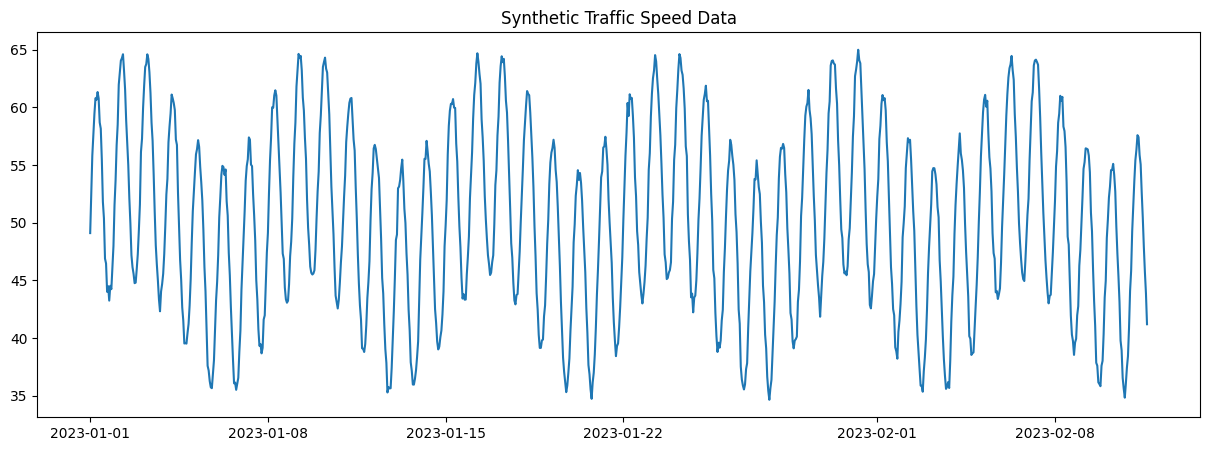

In [2]:
# This creates a fake time-series dataset. 
# In your real project, you will replace this section with loading your real dataset.
def create_synthetic_data():
    # Create a time index
    time = np.arange(0, 1000, 1)
    
    # Create a signal with daily and weekly patterns (seasonality)
    # A base level + a daily pattern (sin wave) + some noise
    daily_pattern = np.sin(time * (2 * np.pi) / 24)  # 24-hour cycle
    weekly_pattern = np.sin(time * (2 * np.pi) / (24 * 7)) # 7-day cycle
    noise = np.random.normal(0, 0.5, len(time))
    
    # Combine them to simulate 'traffic_speed'
    traffic_speed = 50 + 10 * daily_pattern + 5 * weekly_pattern + noise
    
    # Create a Pandas DataFrame
    df = pd.DataFrame({'traffic_speed': traffic_speed})
    df['timestamp'] = pd.date_range(start='2023-01-01', periods=len(time), freq='h')
    df = df.set_index('timestamp')
    return df

data = create_synthetic_data()
print("Data Head:")
print(data.head())

plt.figure(figsize=(15, 5))
plt.plot(data['traffic_speed'])
plt.title("Synthetic Traffic Speed Data")
plt.show()

# --- 2. DATA PREPROCESSING ---

In [3]:
# Get the 'traffic_speed' values
dataset = data['traffic_speed'].values
dataset = dataset.reshape(-1, 1) # Reshape to be 2D for the scaler

# Normalize the data: LSTMs work best with values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# Split into training and testing sets
# For time-series, we split sequentially, not randomly.
train_size = int(len(scaled_dataset) * 0.8)
test_size = len(scaled_dataset) - train_size
train_data = scaled_dataset[0:train_size, :]
test_data = scaled_dataset[train_size:len(scaled_dataset), :]

# Helper function to create time-steps
# LSTMs need data in the form [samples, time_steps, features]
# We will predict the next hour based on the last 'look_back' hours.
def create_time_steps(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# We will look at the past 24 hours to predict the next hour
look_back = 24
X_train, y_train = create_time_steps(train_data, look_back)
X_test, y_test = create_time_steps(test_data, look_back)

# Reshape input to be [samples, time_steps, features] for the LSTM layer
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (775, 24, 1)
y_train shape: (775,)
X_test shape: (175, 24, 1)
y_test shape: (175,)


# --- 3. BUILD THE LSTM MODEL ---

In [4]:
# We need to import the 'Input' layer
from tensorflow.keras.layers import Input

model = Sequential()

# 1. Add the explicit Input layer first. 
#    The shape is (time_steps, features) which is (look_back, 1)
model.add(Input(shape=(look_back, 1)))

# 2. Now add the LSTM layer, but *without* the input_shape argument
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2)) # Dropout layer to prevent overfitting

# Add another LSTM layer
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(1)) # One neuron to predict the one 'traffic_speed' value

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

2025-10-31 04:49:53.599419: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

# --- 4. TRAIN THE MODEL ---

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.1249 - val_loss: 0.0612
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0631 - val_loss: 0.0519
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0529 - val_loss: 0.0277
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0256 - val_loss: 0.0048
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0117 - val_loss: 0.0046
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0106 - val_loss: 0.0040
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0069 - val_loss: 0.0030
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0070 - val_loss: 0.0028
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0064 - val_loss: 0.0026
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0054 - val_loss: 0.0026
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0

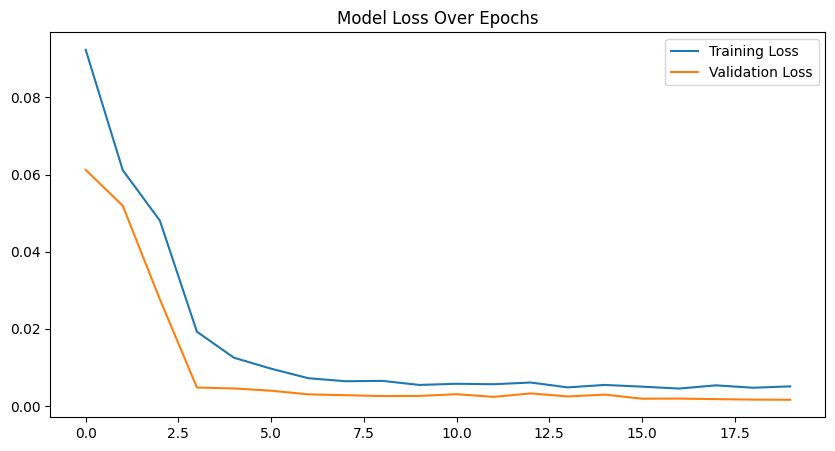

In [5]:
# 'epochs' is the number of times to loop over the entire dataset
# 'batch_size' is how many samples to process at one time
history = model.fit(
    X_train, 
    y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=1
)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

# --- 5. EVALUATE THE MODEL ---

In [6]:
# Make predictions on the test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# **Important:** We must 'invert' the scaling to get the predictions back 
# in the original units (e.g., speed in km/h, not 0-1)
train_predict = scaler.inverse_transform(train_predict)
y_train_orig = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_orig = scaler.inverse_transform([y_test])

# Calculate error metrics (RMSE and MAE)
# These are the numbers you will put in your project report!
train_rmse = np.sqrt(mean_squared_error(y_train_orig[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test_orig[0], test_predict[:, 0]))

train_mae = mean_absolute_error(y_train_orig[0], train_predict[:, 0])
test_mae = mean_absolute_error(y_test_orig[0], test_predict[:, 0])

print(f'\n--- Results ---')
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE:  {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE:  {test_mae:.2f}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

--- Results ---
Train RMSE: 1.26
Test RMSE:  1.22
Train MAE: 1.06
Test MAE:  1.02


# --- 6. PLOT THE PREDICTIONS ---

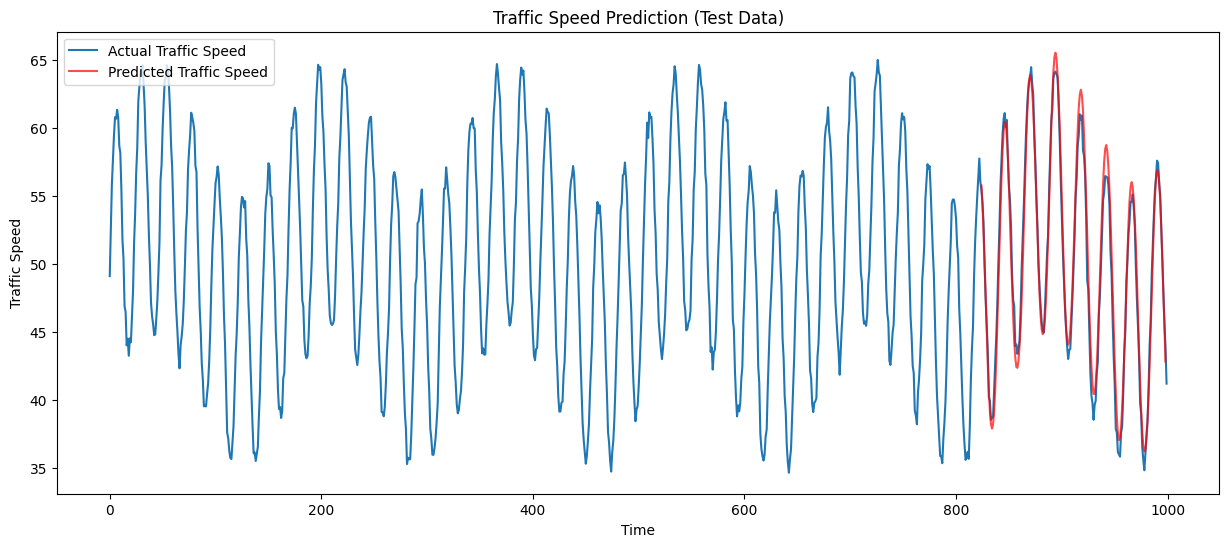

In [7]:
# This is the most important graph for your report.

# Create an empty array for plotting
test_predict_plot = np.empty_like(scaled_dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_data) + look_back : len(scaled_dataset) - 1, :] = test_predict

plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_dataset), label='Actual Traffic Speed')
plt.plot(test_predict_plot, label='Predicted Traffic Speed', color='red', alpha=0.7)
plt.title('Traffic Speed Prediction (Test Data)')
plt.xlabel('Time')
plt.ylabel('Traffic Speed')
plt.legend()
plt.show()